In [11]:
import pandas as pd
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score,KFold
import gc
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
cols = ['Cat','Shots_taken_from_location','Distance_from_hole','Started_at_Z','Hole','Year','Round',
        'Course_#','Player_#','Shot','Hole_Score']
data = pd.concat([pd.read_csv('./../data/%d.csv' % year)[cols] for year in range(2003,2017)])
data = data[data.Cat!='Tee Box']

In [27]:
data.head()

,Cat,Shots_taken_from_location,Distance_from_hole,Started_at_Z,Hole,Year,Round,Course_#,Player_#,Shot,Hole_Score
1,Fairway,4.0,463.466797,15.021,1,2003,1,37,1006,2,5.0
2,Primary Rough,3.0,41.485084,-0.430,1,2003,1,37,1006,3,5.0
3,Green,2.0,12.989014,0.173,1,2003,1,37,1006,4,5.0
4,Green,1.0,0.800701,-0.009,1,2003,1,37,1006,5,5.0
6,Fairway,3.0,312.171448,-6.106,2,2003,1,37,1006,2,4.0


In [28]:
cats = ['Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker','Other']
models = {}
for cat in cats:
    models[cat] = IsotonicRegression()
    models[cat].fit(data[data.Cat==cat].Distance_from_hole,data[data.Cat==cat].Shots_taken_from_location)

In [29]:
data.insert(len(data.columns),'Difficulty_Start',[0]*len(data))
for cat in cats:
    data.loc[data.Cat==cat,'Difficulty_Start'] = models[cat].predict(data[data.Cat==cat].Distance_from_hole)

In [42]:
difficulty_dict = {tuple(tup[:-1]):tup[-1] for tup in 
                  data[['Year','Course_#','Round','Hole','Player_#','Shot','Difficulty_Start']].values.tolist()}

In [45]:
data.insert(len(data.columns),'Difficulty_End',[0]*len(data))
cols = ['Year','Course_#','Round','Hole','Player_#','Shot']
data.loc[data.Shot!=data.Hole_Score,'Difficulty_End'] = [difficulty_dict[tuple(tup[:-1])+tuple([tup[-1]+1])] 
                                                         for tup in data[data.Shot!=data.Hole_Score][cols].values.tolist()]
difficulty_dict = None
gc.collect()

0

In [ ]:
data.insert(len(data.columns),'Strokes_Gained',data.Difficulty_Start - data.Difficulty_End - 1)

In [46]:
data = data.drop(['Year','Course_#','Round','Hole','Player_#','Shot',
                  'Hole_Score','Shots_taken_from_location','Difficulty_Start','Difficulty_End'],axis=1)

In [55]:
data.head()

,Cat,Distance_from_hole,Started_at_Z,Strokes_Gained
1,Fairway,463.466797,15.021,-0.505462
2,Primary Rough,41.485084,-0.430,-0.289120
3,Green,12.989014,0.173,-0.269209
4,Green,0.800701,-0.009,0.000563
6,Fairway,312.171448,-6.106,-0.158991


In [56]:
print data[(data.Cat=='Green') & (data.Started_at_Z>0)].Strokes_Gained.mean()
print data[(data.Cat=='Green') & (data.Started_at_Z<=0)].Strokes_Gained.mean()

-0.0107171334984
0.00223771789587


In [57]:
print data[(data.Cat=='Fairway') & (data.Started_at_Z>0)].Strokes_Gained.mean()
print data[(data.Cat=='Fairway') & (data.Started_at_Z<=0)].Strokes_Gained.mean()

0.00700578291022
0.00444761935907


In [79]:
x_up = data[(data.Cat=='Green') & (data.Started_at_Z<0)].Distance_from_hole.values
y_up = data[(data.Cat=='Green') & (data.Started_at_Z<0)].Strokes_Gained.values
x_down = data[(data.Cat=='Green') & (data.Started_at_Z>0)].Distance_from_hole.values
y_down = data[(data.Cat=='Green') & (data.Started_at_Z>0)].Strokes_Gained.values

bins = np.linspace(0,80,20)
b_up = np.digitize(x_up, bins)
x_up_ms = [x_up[b_up == i].mean() for i in range(1, len(bins))]
y_up_ms = [y_up[b_up == i].mean() for i in range(1, len(bins))]

b_down = np.digitize(x_down, bins)
x_down_ms = [x_down[b_down == i].mean() for i in range(1, len(bins))]
y_down_ms = [y_down[b_down == i].mean() for i in range(1, len(bins))]

In [74]:
bins

array([  0.        ,   4.21052632,   8.42105263,  12.63157895,
        16.84210526,  21.05263158,  25.26315789,  29.47368421,
        33.68421053,  37.89473684,  42.10526316,  46.31578947,
        50.52631579,  54.73684211,  58.94736842,  63.15789474,
        67.36842105,  71.57894737,  75.78947368,  80.        ])

In [71]:
print [len(x_up[b_up==i]) for i in range(1,len(bins))]

[1418741, 488167, 271635, 196941, 153545, 128752, 111746, 94665, 78444, 61952, 47582, 35333, 25813, 18398, 13052, 9103, 6190, 4126, 2692]


In [72]:
def confidence_interval_mean(sample,its,p):
    means = []
    for _ in xrange(its):
        mean = np.mean(np.random.choice(sample,len(sample)))
        means.append(mean)
    return np.percentile(means,[(100.0-p)/2,(p+100.0)/2])

def confidence_interval_difference_of_two_means(sample_1,sample_2,its,p):
    mean_diffs = []
    for _ in xrange(its):
        mean_1 = np.mean(np.random.choice(sample_1,len(sample_1)))
        mean_2 = np.mean(np.random.choice(sample_2,len(sample_2)))
        mean_diffs.append(mean_1 - mean_2)
    return np.percentile(mean_diffs,[(100.0-p)/2,(p+100.0)/2])

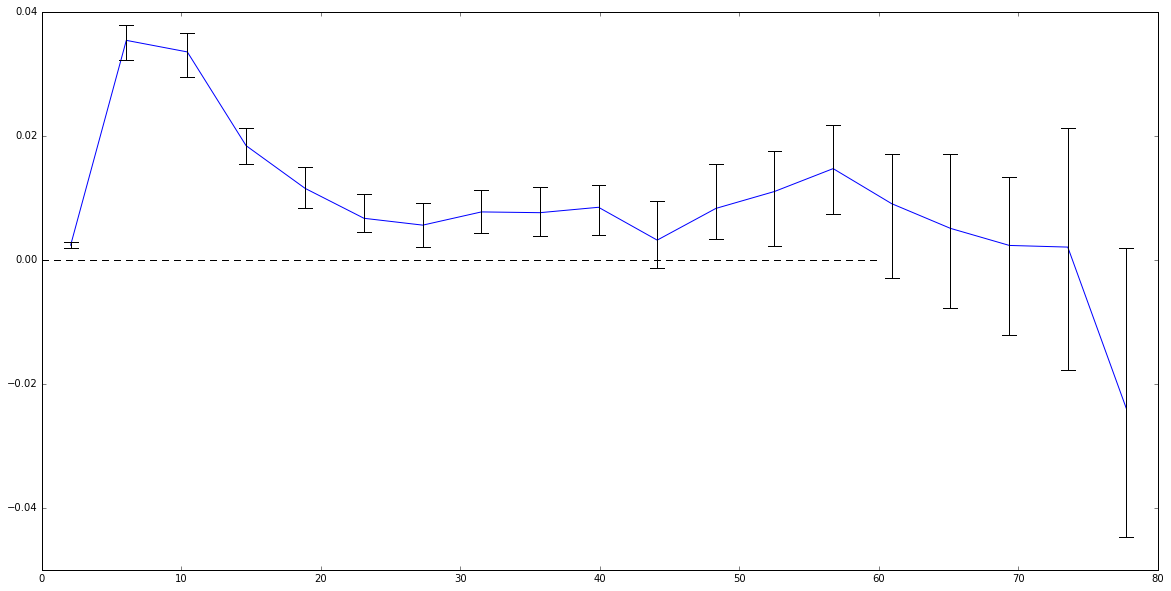

In [80]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot((np.array(x_up_ms)+np.array(x_down_ms))/2,np.array(y_up_ms)-np.array(y_down_ms),label='Advantage of Uphill vs. Downhill')
x = [0,0]
for i in range(len(bins)-1):
    ci = confidence_interval_difference_of_two_means(y_up[b_up == i+1],y_down[b_down == i+1],100,99)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/2, (x_up_ms[i] + x_down_ms[i])/2], [ci[0], ci[1]], 'k-', lw=1)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/2 - .5,(x_up_ms[i] + x_down_ms[i])/2 + .5],[ci[0],ci[0]],'k-', lw=1)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/2 - .5,(x_up_ms[i] + x_down_ms[i])/2 + .5],[ci[1],ci[1]],'k-', lw=1)
    plt.plot([0,60],[0,0],'k--',lw=1)

In [75]:
x_up = data[(data.Cat=='Fairway') & (data.Started_at_Z<0)].Distance_from_hole.values
y_up = data[(data.Cat=='Fairway') & (data.Started_at_Z<0)].Strokes_Gained.values
x_down = data[(data.Cat=='Fairway') & (data.Started_at_Z>0)].Distance_from_hole.values
y_down = data[(data.Cat=='Fairway') & (data.Started_at_Z>0)].Strokes_Gained.values

bins = np.linspace(0,800,20)
b_up = np.digitize(x_up, bins)
x_up_ms = [x_up[b_up == i].mean() for i in range(1, len(bins))]
y_up_ms = [y_up[b_up == i].mean() for i in range(1, len(bins))]

b_down = np.digitize(x_down, bins)
x_down_ms = [x_down[b_down == i].mean() for i in range(1, len(bins))]
y_down_ms = [y_down[b_down == i].mean() for i in range(1, len(bins))]

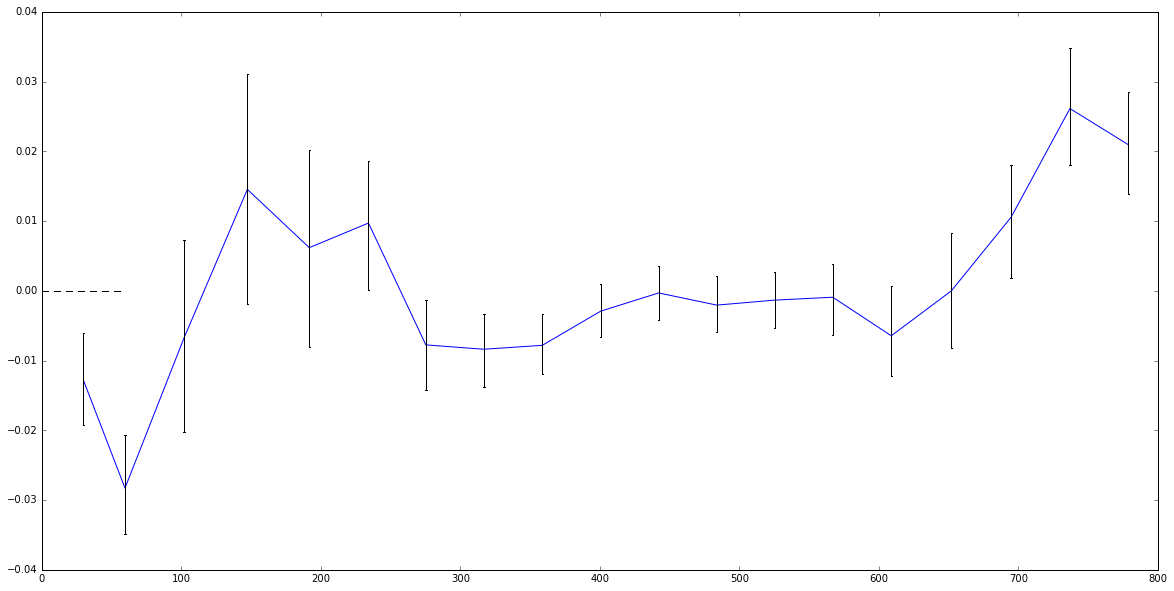

In [76]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot((np.array(x_up_ms)+np.array(x_down_ms))/2,np.array(y_up_ms)-np.array(y_down_ms),label='Advantage of Uphill vs. Downhill')
x = [0,0]
for i in range(len(bins)-1):
    ci = confidence_interval_difference_of_two_means(y_up[b_up == i+1],y_down[b_down == i+1],1000,99)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/2, (x_up_ms[i] + x_down_ms[i])/2], [ci[0], ci[1]], 'k-', lw=1)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/2 - .5,(x_up_ms[i] + x_down_ms[i])/2 + .5],[ci[0],ci[0]],'k-', lw=1)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/2 - .5,(x_up_ms[i] + x_down_ms[i])/2 + .5],[ci[1],ci[1]],'k-', lw=1)
    plt.plot([0,60],[0,0],'k--',lw=1)

In [81]:
x_up = data[(data.Cat=='Primary Rough') & (data.Started_at_Z<0)].Distance_from_hole.values
y_up = data[(data.Cat=='Primary Rough') & (data.Started_at_Z<0)].Strokes_Gained.values
x_down = data[(data.Cat=='Primary Rough') & (data.Started_at_Z>0)].Distance_from_hole.values
y_down = data[(data.Cat=='Primary Rough') & (data.Started_at_Z>0)].Strokes_Gained.values

bins = np.linspace(0,800,20)
b_up = np.digitize(x_up, bins)
x_up_ms = [x_up[b_up == i].mean() for i in range(1, len(bins))]
y_up_ms = [y_up[b_up == i].mean() for i in range(1, len(bins))]

b_down = np.digitize(x_down, bins)
x_down_ms = [x_down[b_down == i].mean() for i in range(1, len(bins))]
y_down_ms = [y_down[b_down == i].mean() for i in range(1, len(bins))]

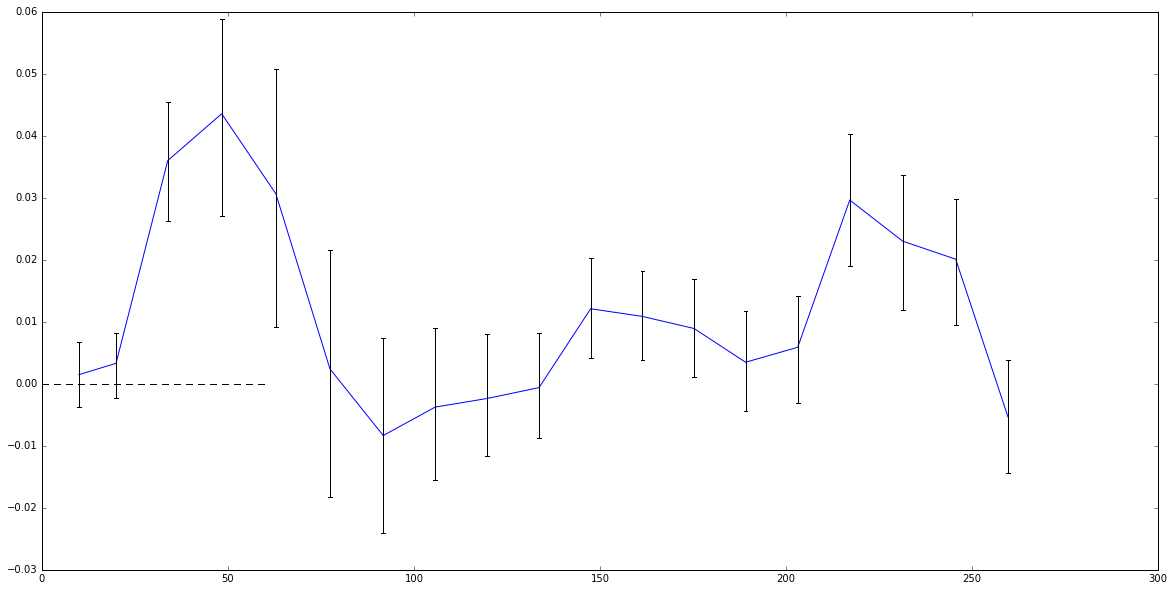

In [85]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot((np.array(x_up_ms)+np.array(x_down_ms))/6,np.array(y_up_ms)-np.array(y_down_ms),label='Advantage of Uphill vs. Downhill')
x = [0,0]
for i in range(len(bins)-1):
    ci = confidence_interval_difference_of_two_means(y_up[b_up == i+1],y_down[b_down == i+1],1000,99)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/6, (x_up_ms[i] + x_down_ms[i])/6], [ci[0], ci[1]], 'k-', lw=1)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/6 - .5,(x_up_ms[i] + x_down_ms[i])/6 + .5],[ci[0],ci[0]],'k-', lw=1)
    plt.plot([(x_up_ms[i] + x_down_ms[i])/6 - .5,(x_up_ms[i] + x_down_ms[i])/6 + .5],[ci[1],ci[1]],'k-', lw=1)
    plt.plot([0,60],[0,0],'k--',lw=1)

In [86]:
data.insert(len(data.columns),'Elevation_Grade',-data.Started_at_Z/data.Distance_from_hole)

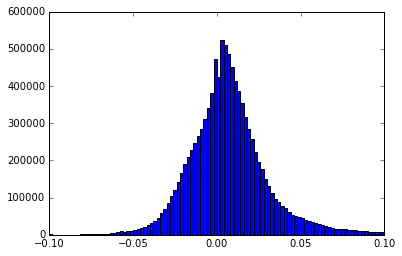

In [99]:
plt.hist(data.Elevation_Grade[(-.1<data.Elevation_Grade) & (.1>data.Elevation_Grade)],bins=100);

In [90]:
data.Elevation_Grade.describe()

count    1.048525e+07
mean     7.610789e-03
std      2.808579e-02
min     -1.365459e+01
25%     -6.940707e-03
50%      5.273072e-03
75%      1.822364e-02
max      3.888219e+00
Name: Elevation_Grade, dtype: float64

In [95]:
(data.Elevation_Grade<-3).sum()

10

In [108]:
x = data[data.Cat=='Green'].Elevation_Grade.values
y = data[data.Cat=='Green'].Strokes_Gained.values

bins = np.linspace(-.1,.1,20)
b = np.digitize(x, bins)

In [109]:
print [len(x[b==i]) for i in range(1,len(bins))]

[478, 844, 1658, 4464, 15341, 65989, 247569, 633688, 1036721, 1256812, 1234874, 840036, 350592, 103800, 30561, 7948, 2523, 1147, 704]


In [120]:
x_ms = np.array([x[b==i].mean() for i in range(1,len(bins))])
y_ms = np.array([y[b==i].mean() for i in range(1,len(bins))])

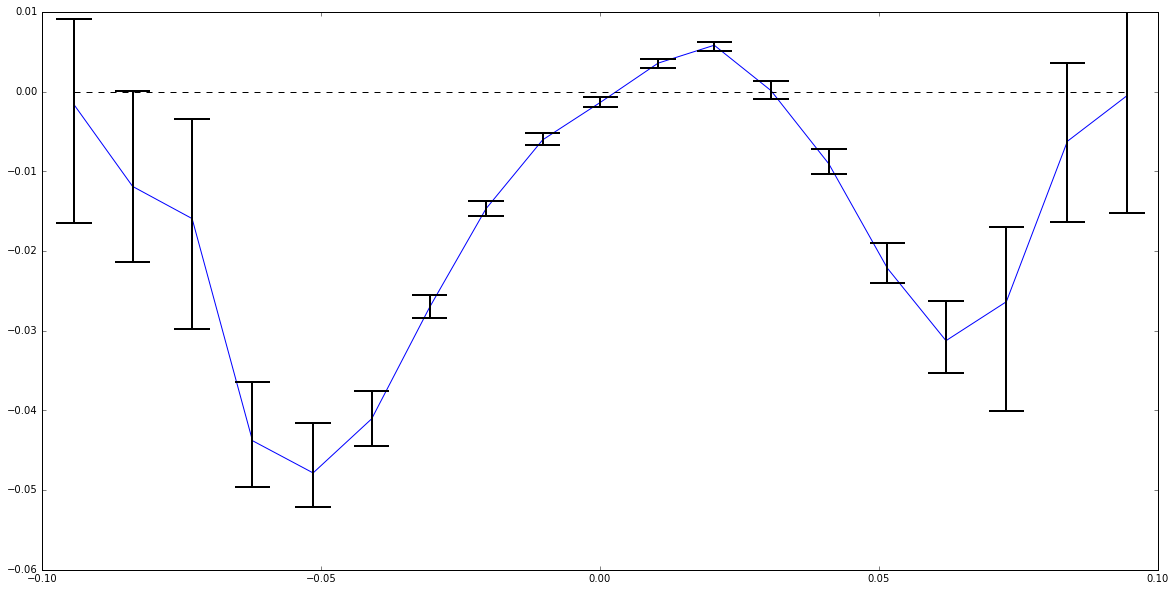

In [121]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot(x_ms,y_ms)
for i in range(len(bins)-1):
    ci = confidence_interval_mean(y[b == i+1],50,99)
    plt.plot([x_ms[i],x_ms[i]], [ci[0], ci[1]], 'k-', lw=2)
    plt.plot([x_ms[i] - .003,x_ms[i] + .003],[ci[0],ci[0]],'k-', lw=2)
    plt.plot([x_ms[i] - .003,x_ms[i] + .003],[ci[1],ci[1]],'k-', lw=2)
plt.plot([x_ms.min(),x_ms.max()],[0,0],'k--',lw=1)

In [7]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.5, n_estimators=5, subsample=1.0, 
                                criterion='friedman_mse', min_samples_split=10, min_samples_leaf=5, 
                                max_depth=3, verbose=0)

In [22]:
cols = ['Cat','Shots_taken_from_location','Distance_from_hole','Started_at_Z','Hole','Year','Round',
        'Course_#','Green_to_work_with']
data = pd.concat([pd.read_csv('./../data/%d.csv' % year)[cols] for year in range(2003,2017)])
data = data[data.Cat!='Tee Box']

In [14]:
results = {}
for cat,df in data.groupby('Cat'):
    X = df.Distance_from_hole.values
    y = df.Shots_taken_from_location.values
    cv = KFold(n_splits=9)
    scores = []
    for train,test in cv.split(X):
        gbr.fit(X[train][:,None],y[train])
        scores.append(gbr.score(X[test][:,None],y[test]))
    results[cat] = scores

In [17]:
results_with_slope = {}
for cat,df in data.groupby('Cat'):
    X = df[['Distance_from_hole','Started_at_Z']].values
    y = df.Shots_taken_from_location.values
    cv = KFold(n_splits=9)
    scores = []
    for train,test in cv.split(X):
        gbr.fit(X[train],y[train])
        scores.append(gbr.score(X[test],y[test]))
    results_with_slope[cat] = scores

In [23]:
results_with_gtww = {}
for cat,df in data.groupby('Cat'):
    X = df[['Distance_from_hole','Started_at_Z','Green_to_work_with']].values
    y = df.Shots_taken_from_location.values
    cv = KFold(n_splits=9)
    scores = []
    for train,test in cv.split(X):
        gbr.fit(X[train],y[train])
        scores.append(gbr.score(X[test],y[test]))
    results_with_gtww[cat] = scores

In [19]:
cats = ['Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker','Other']

In [26]:
for cat in cats:
    print cat,np.mean(results[cat]),np.mean(results_with_slope[cat]),np.mean(results_with_gtww[cat])

Green 0.588673304514 0.588885717815 0.588885717815
Fairway 0.291884934671 0.292381610524 0.292546241356
Intermediate Rough 0.433410221882 0.434139126366 0.434827565664
Primary Rough 0.387295261544 0.388317821544 0.391242329674
Fringe 0.12121245548 0.123131695684 0.123306753973
Bunker 0.367211620502 0.368500405351 0.368958223052
Other 0.202696730259 0.205818329212 0.206071574383
